In [1]:
# matlab-stuff  kaggle-house 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBRegressor

In [2]:
# read in data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# save shape for splitting later
ntrain = train.shape[0]
ntest = test.shape[0]

In [3]:
# Let's look at a heatmap of the features
corr = train.corr()
#plt.subplots(figsize=(20, 20))
#sns.heatmap(corr, cmap='rainbow', vmax=0.9, square=True)

In [4]:
# Now concatenate the training and test data so we can fill in missing variables
y_train = train.SalePrice.values
allData = pd.concat((train, test)).reset_index(drop=True)
allData.drop(['SalePrice'], axis=1, inplace=True)

all_data_na = (allData.isnull().sum() / len(allData)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missingDataPlot = pd.DataFrame({'Missing Ratio' : all_data_na})
#missingDataPlot

In [5]:
# Fill in any NA values with "None" where it applies
allData['PoolQC'] = allData['PoolQC'].fillna("None")
allData['MiscFeature'] = allData['MiscFeature'].fillna("None")
allData['Alley'] = allData['Alley'].fillna("None")
allData['Fence'] = allData['Fence'].fillna("None")
allData['FireplaceQu'] = allData['FireplaceQu'].fillna("None")
allData['BsmtExposure'] = allData['BsmtExposure'].fillna("None")
allData['BsmtCond'] = allData['BsmtCond'].fillna("None")
allData['BsmtQual'] = allData['BsmtQual'].fillna("None")
allData['BsmtFinType1'] = allData['BsmtFinType1'].fillna("None")
allData['BsmtFinType2'] = allData['BsmtFinType2'].fillna("None")

# Is this the best way to handle this (in this case, None = None)
allData['MasVnrType'] = allData['MasVnrType'].fillna("None")

In [6]:
# zoning is mixed type (objects etc). by forcing str, the fillna works again
allData['MSZoning']=allData['MSZoning'].astype(str)
allData['KitchenQual']=allData['KitchenQual'].astype(str)
allData['Exterior1st']=allData['Exterior1st'].astype(str)
allData['Exterior2nd']=allData['Exterior2nd'].astype(str)
allData['Electrical']=allData['Electrical'].astype(str)
# mszoning has a special "nan" that is not np.nan
# allData['MSZoning'] = allData['MSZoning'].replace({"nan" : allData['MSZoning'].mode()},regex=True)

In [7]:
# Other features will require numerical data
allData['GarageCars'] = allData['GarageCars'].fillna(0)
allData['BsmtFullBath'] = allData['BsmtFullBath'].fillna(0)
allData['BsmtHalfBath'] = allData['BsmtHalfBath'].fillna(0)
allData['BsmtUnfSF'] = allData['BsmtUnfSF'].fillna(0)
allData['TotalBsmtSF'] = allData['TotalBsmtSF'].fillna(0)
allData['BsmtFinSF1'] = allData['TotalBsmtSF'].fillna(0)
allData['BsmtFinSF2'] = allData['TotalBsmtSF'].fillna(0)

In [8]:
# Drop features that may skew data if their missing data is filled with 0 or None
allData.drop(['GarageArea'], axis=1, inplace=True)
allData.drop(['GarageYrBlt'], axis=1, inplace=True)
allData.drop(['GarageQual'], axis=1, inplace=True)
allData.drop(['GarageCond'], axis=1, inplace=True)
allData.drop(['GarageFinish'], axis=1, inplace=True)
allData.drop(['GarageType'], axis=1, inplace=True)
allData.drop(['MasVnrArea'], axis=1, inplace=True)

In [9]:
# Special Cases: LotFrontage, MSZoning, Utilities, Electrical, Exterior1st, Exterior2nd, Functional
# For the following features, it may be safe to asusme that there is consistency within
# the neighborhood. We can fill with a value based on the other houses in that neighborhood
allData['LotFrontage'] = allData.groupby("Neighborhood")['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# TODO
# Should this be mode of neighborhood?
# Need to make sure that we are not filling in a nan value with nan
allData['MSZoning'] = allData.groupby("Neighborhood")['MSZoning'].transform(
    lambda x: x.replace("nan", x.mode()[0]))


allData['Exterior2nd'] = allData.groupby("Neighborhood")['Exterior2nd'].transform(
    lambda x: x.replace("nan", "woogiewoogie"))

allData['Exterior1st'] = allData.groupby("Neighborhood")['Exterior1st'].transform(
    lambda x: x.replace("nan", "woogiewoogie"))

# allData['MSZoning'] = allData['MSZoning'].fillna(allData['MSZoning'].mode())

# TODO
# Should this be by year or neighborhood?
allData['Electrical'] = allData.groupby("Neighborhood")['Electrical'].transform(
    lambda x: x.fillna(x.mode()))

# TODO
# Should these be mode of neighborhood?
allData['Exterior1st'] = allData.groupby("Neighborhood")['Exterior1st'].transform(
    lambda x: x.fillna(x.mode()))
allData['Exterior2nd'] = allData.groupby("Neighborhood")['Exterior2nd'].transform(
    lambda x: x.fillna(x.mode()))

In [10]:
# Data description states to assume  Typical funtionality unless otherwise stated
allData['Functional'] = allData['Functional'].fillna("Typ")

# In data description, WD == Warranty Deed - Conventional
allData['SaleType'] = allData['SaleType'].fillna("WD")

# For Utilities, the vast majority of the houses have the same value.
missingDataPlot = [x for x in allData['Utilities'] if x != "AllPub"]
#missingDataPlot

# Only three of these houses do not have "AllPub." 
# The "NoSeWa" is in the training set. 
# The feature is therefore useless to us for prediction

In [11]:
# TODO
# Do we also drop the house that has NoSeWa?
allData.drop(['Utilities'], axis=1, inplace=True)

# Check one more time to make sure we have not missed any missing data
nan_rows = allData[allData.isnull().T.any().T]
#nan_rows

In [12]:
all_data_na = (allData.isnull().sum() / len(allData)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missingDataPlot = pd.DataFrame({'Missing Ratio' : all_data_na})
#missingDataPlot

In [13]:
# change 'secretly ordinal' features into numerical ones, provide more data to the model
has_rank = [col for col in allData if 'TA' in list(allData[col])]
dic_num = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
allData['MSSubClass'] = allData['MSSubClass'].astype('category')

for col in has_rank:
    allData[col+'_2num'] = allData[col].map(dic_num)

allData = pd.get_dummies(allData)
d_cols = allData.select_dtypes(include=['number']).columns
allData = allData[d_cols]
allData = allData.fillna(allData.median())

In [14]:
# identify skew for numerical features
cols = [col for col in allData if '_2num' in col or '_' not in col]
skew = [abs(stats.skew(allData[col])) for col in allData if '_2num' in col or '_' not in col]
skews = pd.DataFrame()
skews['Columns'] = cols
skews['Skew_Magnintudes'] = skew
cols_unskew = skews[skews.Skew_Magnintudes > 1].Columns
allData_unskew = allData.copy()

# replace with log(n+1)
for col in cols_unskew:
    allData_unskew[col] = np.log1p(allData[col])

# unskew SalePrice
y_train_unskew = np.log1p(y_train)

In [15]:
# get rid of annoying warning that we thought was an error
pd.options.mode.chained_assignment = None  # default='warn'

# Split the testing and training data back into two collections
train = allData_unskew.query("Id < 1461")
train['SalePrice'] = y_train_unskew
test = allData_unskew.query("Id >= 1461")

In [17]:
# identify outliers (SLOW)
X = train.drop(['SalePrice','Id'], axis = 1)
model = sm.OLS(y_train_unskew,X)
results = model.fit()
bonf_test = results.outlier_test()['bonf(p)']
bonf_outlier = list(bonf_test[bonf_test<1e-2].index)
bonf_outlier

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:323: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/stats/multitest.py:147: RuntimeWarning: invalid value e

[30, 88, 462, 523, 588, 632, 825, 968, 970, 1324, 1432, 1453]

In [18]:
# remove outliers from training data
train_good = train.drop(bonf_outlier, axis=0)
y_train_good = np.delete(y_train_unskew, bonf_outlier)

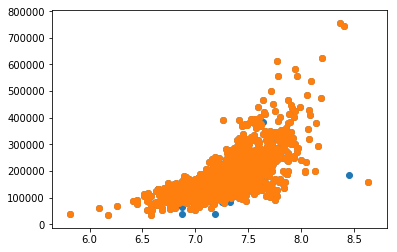

In [19]:
# DEBUG = plot some stuff, see if outliers are really gone
plt.scatter(train['GrLivArea'],y_train)
plt.scatter(train_good['GrLivArea'],np.expm1(y_train_good))

In [20]:
# ---------- EXPORT CLEAN DATA ----------

# Then write the data sets to a csv
train_good.to_csv('p_train.csv')
test.to_csv('p_test.csv')

# check Id nums
#file = pd.read_csv('p_test.csv')
#file["Id"]

In [21]:
# ---------- LINEAR REGRESSION ----------

x_train = train_good.drop(['SalePrice', 'Id'], axis=1)
x_test  = test.drop(['Id'], axis=1)

In [22]:
# Random Forest Regressor
rf_test = RandomForestRegressor(max_depth=30, n_estimators=500, max_features=100, oob_score=True, random_state=1234)
rf_test.fit(x_train, y_train_good)
preds_rf = np.expm1(rf_test.predict(x_test))    # expm1 (inv of logp1) un-normalizes the dependent variable SalePrice

In [23]:
# XGB regressor
xgb_test = XGBRegressor(learning_rate=0.05, n_estimators=500, max_depth=3, colsample_bytree=0.4)
xgb_test.fit(x_train, y_train_good)
preds_xgb = np.expm1(xgb_test.predict(x_test))

In [24]:
# LassoCV
scaler = StandardScaler()
LCV = LassoCV()
scale_LCV = Pipeline([('scaler', scaler), ('LCV', LCV)])
scale_LCV.fit(x_train, y_train_good)
preds_lasso = np.expm1(scale_LCV.predict(x_test))

In [25]:
# average the predictions of both regressors
preds = (preds_xgb + preds_lasso + preds_rf)/3

In [26]:
# ---------- EXPORT PREDICTIONS ----------
out_preds = pd.DataFrame()
out_preds['Id'] = test['Id']
out_preds['SalePrice'] = preds
out_preds.to_csv('output.csv', index=False)